## Importing the necessary libraries

In [1]:
from __future__ import print_function, division
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

### Downloading the data
also rescaling the data between [-1, 1]

In [2]:
(training_data, _), (_, _) = fashion_mnist.load_data()

X_train = training_data / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=3)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Building the Generator part of our GAN

In [3]:
def build_generator():
  generator = Sequential()
  generator.add(Dense(128 * 7 * 7, activation="relu", input_dim=100))
  generator.add(Reshape((7, 7, 128)))
  generator.add(UpSampling2D())

  generator.add(Conv2D(128, kernel_size=3, padding="same",
                       activation="relu"))
  generator.add(BatchNormalization(momentum=0.8))
  generator.add(UpSampling2D())

  # convolutional + batch normalization layers
  generator.add(Conv2D(64, kernel_size=3, padding="same",
                       activation="relu"))
  generator.add(BatchNormalization(momentum=0.8))

  # convolutional layer with filters = 1
  generator.add(Conv2D(1, kernel_size=3, padding="same",
                       activation="relu"))

  # we can view the summart here
  generator.summary()

  noise = Input(shape=(100,))
  fake_image = generator(noise)
  return Model(inputs=noise, outputs=fake_image)

### Now we build the discriminator

In [4]:
def build_discriminator():
  discriminator = Sequential()
  discriminator.add(Conv2D(32, kernel_size=3, strides=2,
                           input_shape=(28,28,1), padding="same"))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(0.25))

  discriminator.add(Conv2D(64, kernel_size=3, strides=2,
                           padding="same"))
  discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
  discriminator.add(BatchNormalization(momentum=0.8))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(0.25))

  discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
  discriminator.add(BatchNormalization(momentum=0.8))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(0.25))

  discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
  discriminator.add(BatchNormalization(momentum=0.8))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(0.25))

  discriminator.add(Flatten())
  discriminator.add(Dense(1, activation='sigmoid'))

  img = Input(shape=(28,28,1))
  probability = discriminator(img)
  return Model(inputs=img, outputs=probability)

### Here we build the "combined" model
consisting of both discriminatio and generator

In [5]:
# Input shape
img_shape = (28,28,1)
channels = 1
latent_dim = 100

optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Build the generator
generator = build_generator()

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 6272)           │       633,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 1)      │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 856,193 (3.27 MB)

 Trainable params: 855,809 (3.26 MB)

 Non-trainable params: 384 (1.50 KB)

### Defining a function to plot the images while training our DCGAN model

In [6]:
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

### The final part: the Training func

In [7]:
def train(epochs, batch_size=128, save_interval=50):

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Sample noise and generate a batch of new images
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise)

        # Train the discriminator (real classified as ones and generated as zeros)
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        # Train the generator (wants discriminator to mistake images as real)
        g_loss = combined.train_on_batch(noise, valid)

        # Plot the progress
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            plot_generated_images(epoch, generator)

### Lets train what we have created..!

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.690087, acc.: 52.34%] [G loss: 0.696061]
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1 [D loss: 0.690674, acc.: 52.08%] [G loss: 0.693896]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2 [D loss: 0.688761, acc.: 51.98%] [G loss: 0.692630]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3 [D loss: 0.688913, acc.: 50.86%] [G loss: 0.690738]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
4 [D loss: 0.689695, acc.: 49.72%] [G loss: 0.690461]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
5 [D loss: 0.689683, acc.: 49.36%] [G loss: 0.687861]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6 [D loss: 0.689632, acc.: 49.34%] [G loss: 0.685893]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
7 [D loss: 0.689282, acc.: 49.71%] [G loss: 0.684354]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
8 [D loss: 0.689344, acc.: 49.58%] [G loss: 0.684082]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
9 [D loss: 0.689537, acc.: 49.22%] [G loss: 0.682037]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
10 [D loss: 0.689673, acc.: 49.00%] [G lo

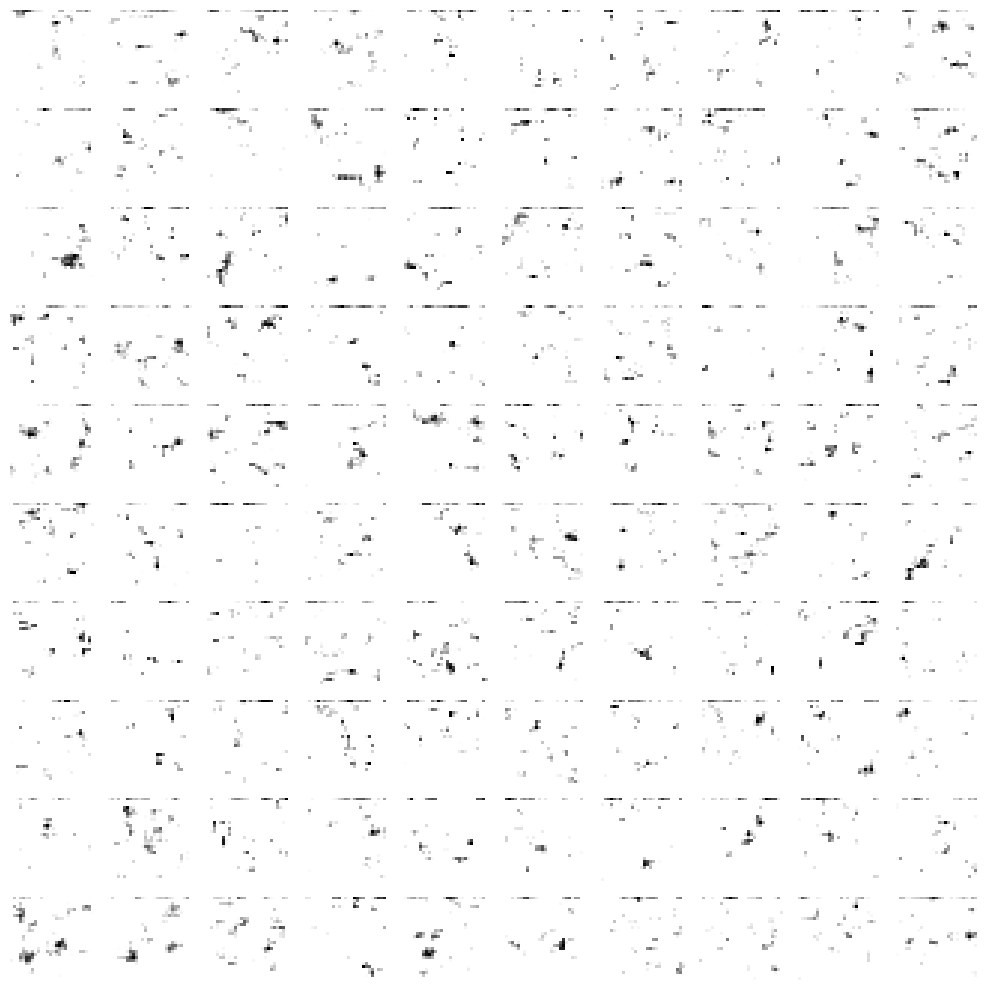

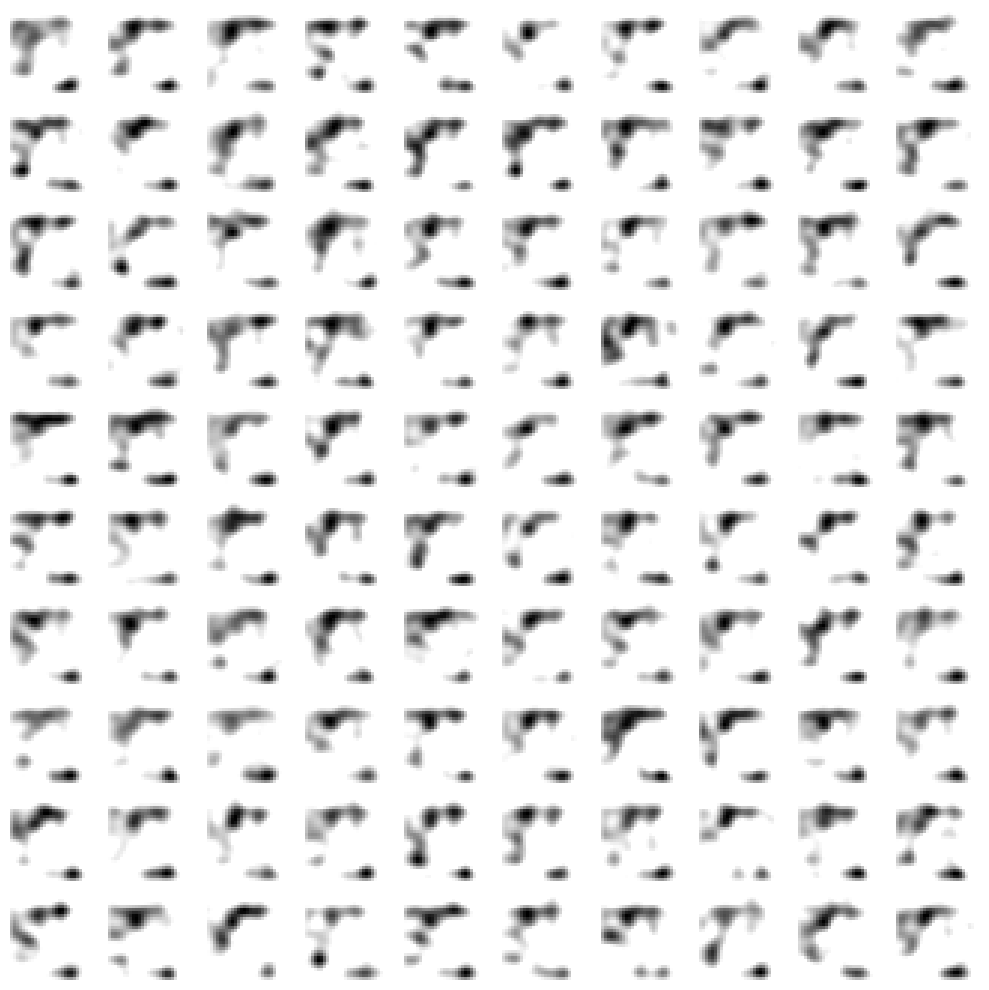

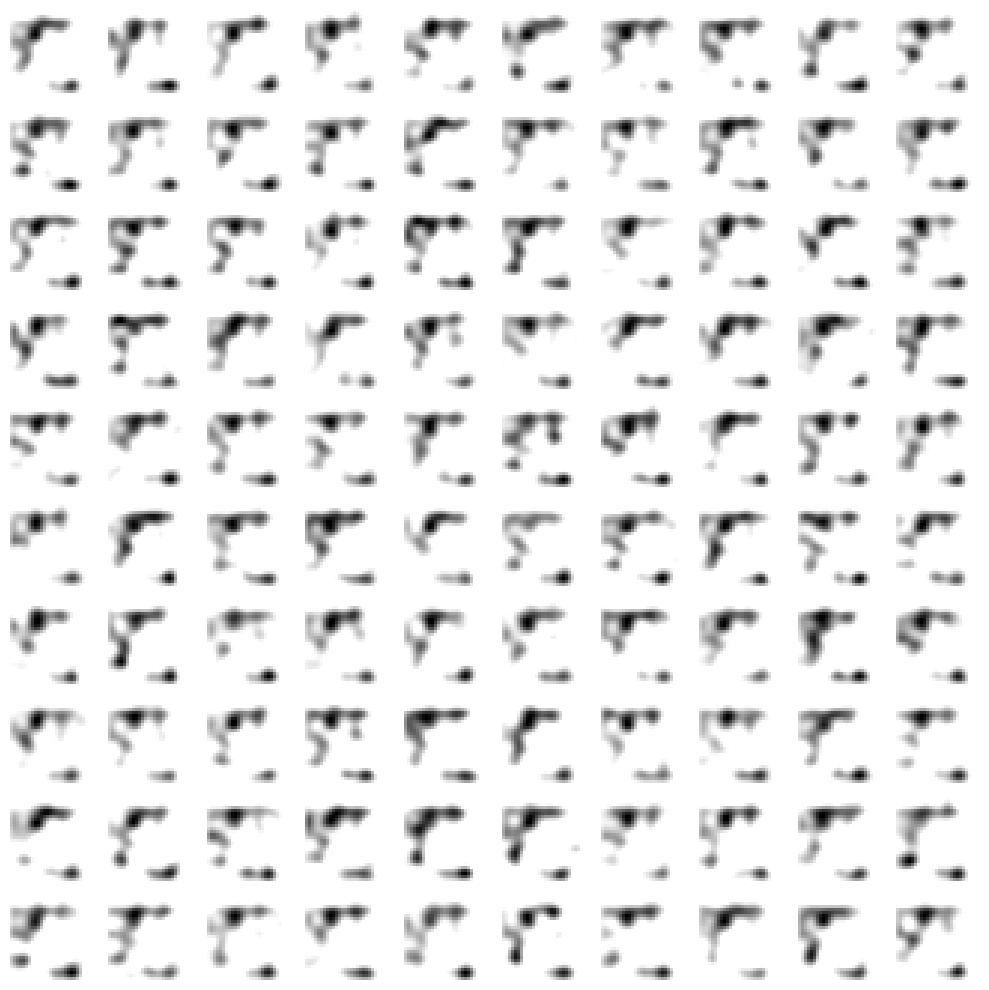

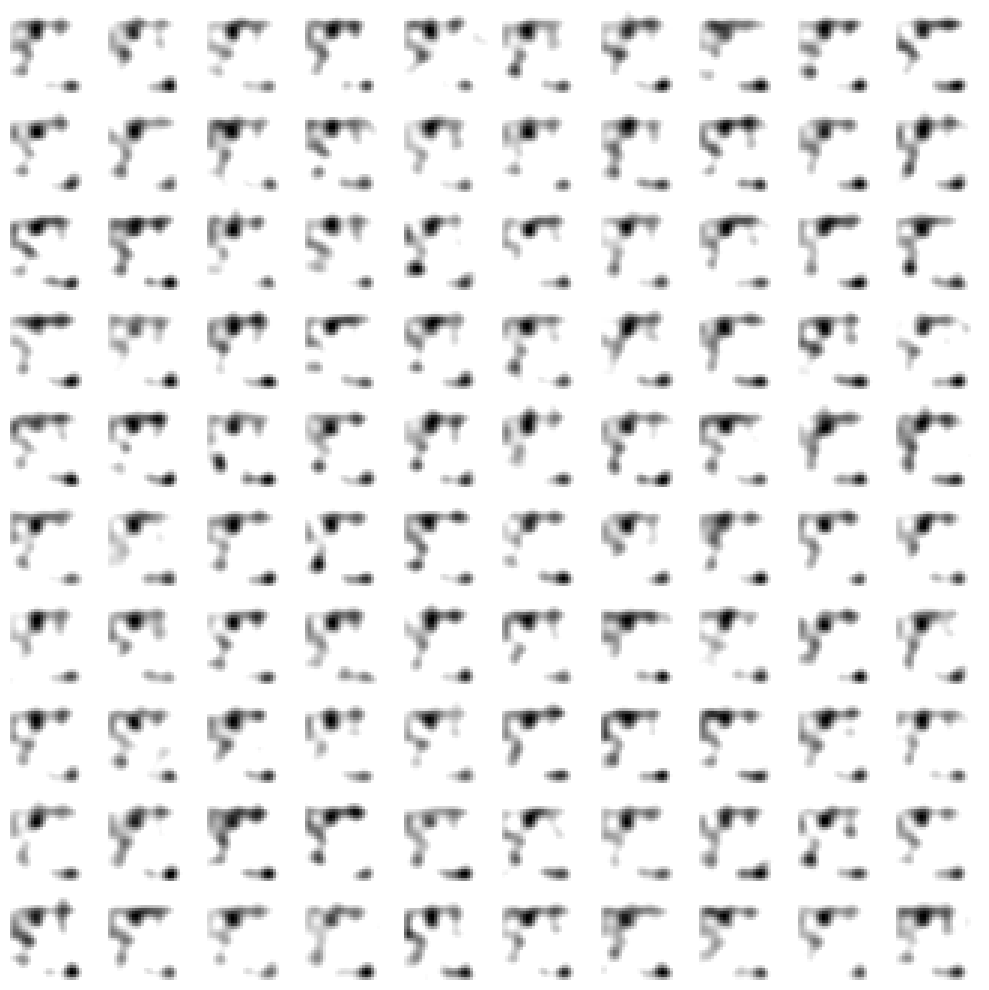

In [8]:
train(epochs=1000, batch_size=32, save_interval=250)